In [104]:
from facelive.task.landmark import FaceLandmarkTask
from facelive.models.landmark import FaceLandmarkNet
from facelive.data.datamodule import IBug300WDataModule, IBugDlib300WDataModule

import cv2 
import numpy as np

In [101]:
task = FaceLandmarkTask.load_from_checkpoint('checkpoints/facelandmark-eepoch=22-val_loss=0.4190-val_avg=4.7749.ckpt')

In [102]:
model = task.model
net = model

In [105]:
dmod = IBugDlib300WDataModule(data_dir='/data/vision/landmark/ibug_300W_dlib/')
dmod.setup()

In [107]:
loader = dmod.val_dataloader()

In [108]:
sample = next(iter(loader))

In [109]:
# sample['image']

In [110]:
import torch


In [111]:
output = model((sample["image"]).type(torch.FloatTensor))

In [112]:
import matplotlib.pyplot as plt
# helper function to display keypoints
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')

In [113]:
images = sample["image"]

In [114]:
idx = 10
image = images[idx].squeeze()
key_pts = output[idx]

In [115]:
keypoints = key_pts.detach().view(-1,2)

In [116]:
# # key_pts = (key_pts*50)+100
# keypoints = keypoints * (224/3.5)
# keypoints = keypoints + [x+w/3,y+h/2]
# keypoints = keypoints.astype(np.int32)

In [117]:
# key_pts = key_pts.numpy()

In [118]:
# plt.imshow(image, cmap='gray')

In [119]:
# show_keypoints(image, key_pts*10)

In [120]:
def read_faces(image):
    # switch red and blue color channels 
    # --> by default OpenCV assumes BLUE comes first, not RED as in many images
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # load in a haar cascade classifier for detecting frontal faces
    face_cascade = cv2.CascadeClassifier('detector/haarcascade_frontalface_default.xml')

    # run the detector
    # the output here is an array of detections; the corners of each detection box
    # if necessary, modify these parameters until you successfully identify every face in a given image
    faces = face_cascade.detectMultiScale(image, 1.2, 2)

    # make a copy of the original image to plot detections on
    image_with_detections = image.copy()

    # loop over the detected faces, mark the image where each face is found
    for (x,y,w,h) in faces:
        # draw a rectangle around each detected face
        # you may also need to change the width of the rectangle drawn depending on image resolution
        cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 

    return faces




In [121]:
#The Variable API has been deprecated: https://pytorch.org/docs/master/autograd.html#variable-deprecated
#from torch.autograd import Variable

def draw_keypoints(image, faces):
    # loop over the detected faces from your haar cascade
    # print(faces)
    for (x,y,w,h) in faces:
        image_copy = np.copy(image)
        # Select the region of interest that is the face in the image 
        #roi = image_copy[y:y+h, x:x+w]
        roi = image_copy[y:y + int(1.5 * h), x - int(0.5 * w):x + int(1.0 * w)] # the face images are too big

        ## TODO: Convert the face region from RGB to grayscale
        roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
        #plt.imshow(roi, cmap = 'gray')

        ## TODO: Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
        roi = roi / 255.


        ## TODO: Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
        roi = cv2.resize(roi, (224, 224))

        ## TODO: Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
        roi = np.reshape(roi, (1, 1, 224, 224))

        ## TODO: Make facial keypoint predictions using your loaded, trained network 
        ## perform a forward pass to get the predicted facial keypoints

        roi_torch = torch.from_numpy(roi)
        roi_torch = roi_torch.type(torch.FloatTensor)
        # print(roi_torch.shape)
        net.eval()
        keypoints = net(roi_torch)
        keypoints = keypoints.data.numpy()
        keypoints = np.reshape(keypoints, (68, -1)) # reshape to 2 X 68 keypoint for the fase
        keypoints = keypoints * (224/3.5)
        keypoints = keypoints + [x+w/3,y+h/2]
        keypoints = keypoints.astype(np.int32)

        # print(keypoints.shape)
        # print(keypoints)
        ## TODO: Display each detected face and the corresponding keypoints        

        image_copy = roi_torch.squeeze(0).numpy()   
        image_copy = np.transpose(image_copy, (1, 2, 0))  # Convert to numpy image shape (H x W x C)
        image_copy = np.squeeze(image_copy)
        for pts in keypoints:
            cv2.circle(image, pts, 1, (255,255,255), 2)
        # cv2.drawKeypoints(image_copy, keypoints, image_copy, (255,0,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        # plt.figure(figsize=(5,5))
        # plt.imshow(image_copy, cmap='gray')
        # plt.scatter(keypoints[:, 0], keypoints[:, 1], s=20, marker='.', c='m')
    
    image = cv2.cvtColor(image,  cv2.COLOR_BGR2RGB)
    return image
    

In [122]:
def read_face_draw_keypoints(image):
    faces = read_faces(image)
    image_drawed = draw_keypoints(image, faces)
    return image_drawed

CPU times: user 1.28 s, sys: 46.2 ms, total: 1.33 s
Wall time: 187 ms


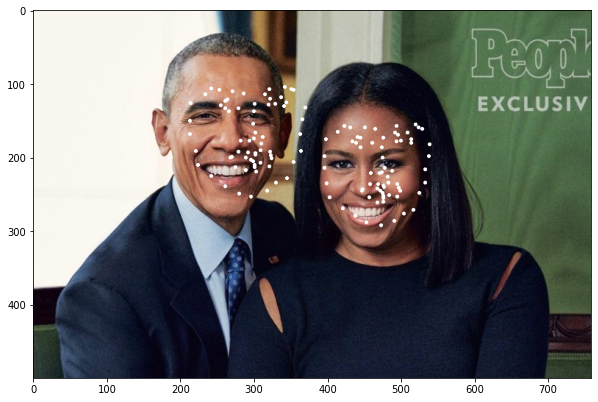

In [123]:
%%time
image = cv2.imread('assets/images/obamas.jpg')

faces = read_faces(image)
image_drawed = draw_keypoints(image, faces)
plt.figure(figsize=(10,10))
plt.imshow(image_drawed, cmap='gray')